<a href="https://colab.research.google.com/github/DmitryKhrenov/Autoencoder/blob/main/%D0%A1%D1%82%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2%D0%BA%D0%B0_Selector_Autoembeding_29_03_23_%D0%98%D0%B7%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%B0_%D0%BA%D0%B0%D1%80%D1%82%D0%B8%D0%BD%D0%BE%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Библиотеки / Константы

#### Libraries

In [ ]:
###-------  Подключаем общие библиотеки --------------
import os
import math


# Подключение библиотеки для работы с массивами
import numpy as np 
# Подключение библиотеки для генерации случайных чисел
import random

# Подключение библиотек для отрисовки изображений
import matplotlib.pyplot as plt 
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline 

# Подключение класса для работы с изображением
from PIL import Image, ImageOps
import cv2
from google.colab.patches import cv2_imshow

import tensorflow as tf

###------------- Библиотеки Keras ---------------
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, BatchNormalization, Dropout, Rescaling, Conv2DTranspose, Reshape
from keras.models import Model, Sequential
from keras.utils import to_categorical
#from keras.preprocessing.image import image_dataset_from_directory , load_img, img_to_array
#from keras.preprocessing.image import load_img, img_to_array

# Оптимизатор
from keras.optimizers import Adam

# Подключение утилит для to_categorical
from tensorflow.keras import utils 

In [ ]:
###------------ Общие константы -------------
#data_arch_file='/content/drive/MyDrive/Images.rar'
#DATA_DIR = '/content/drive/MyDrive/images'
#DATA_DIR = '/content/images'
#DATA_DIR = '/content/Selector_new'
#TRAIN_DIR = DATA_DIR + '/training'
#VAL_DIR = DATA_DIR + '/validation'


image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.webp']  # расширения картинок

# Размер входного изображения
img_width, img_height = 515, 512
image_color_schem = 'rgb'
img_num_chanels = len(image_color_schem)
input_shape = (img_width, img_height, img_num_chanels)   #!!! размерность по цветам получать  из изображени и  принудительно приводить

num_classes = 13    ### получать из папок
batch_size = 32
epochs = 20
#num_classes = 10 

### Функции 

#### Подготовка структуры папок с картинками к загрузке
Проверяем, есть ли папка DATA_DIR
Есть ли в ней подпапки 'training', 'validation'
если DATA_DIR есть, а разделения нет, то считаем, что все подпапки - это катеогрии. и разделяем их уже на валидационную и тестовую выборки

#### **unpackingRAR**(rar_file = '/content/drive/MyDrive/Images.rar')

In [ ]:
def unpackingRAR(rar_file = '/content/drive/MyDrive/Images.rar'):
    dir_list = os.listdir('.')
    dir_list = [d for d in dir_list if os.path.isdir(d)]
    !unrar x -inul $rar_file
    !unzip -q $data_arch_file       # кто то из двух сработает

    after_dir_list = os.listdir('.')
    after_dir_list = [d for d in after_dir_list if os.path.isdir(d)]
    return list(set(after_dir_list) - set(dir_list))[0]    # возвращает куда были распакованы файлы


#### **images_dir_stats**(folder = '/content', show_diag = False)
получение среднего значения разрешения и числа каналов для всех картнок


In [ ]:
# получение среднего значения разрешения и числа каналов для всех картнок
def images_dir_stats(folder = '/content', show_diag = False): #/images
    
    shapes_lst = []         #список кортежей разрешений файлов
    i = 0
    for root, dirs, files in os.walk(folder):
        for file in files:            
            if any(file.endswith(ext) for ext in image_extensions):
                # Если это картинка, открываем ее и получаем информацию
                with Image.open(os.path.join(root, file)) as img:
                    res = img.size
                    mode = len(img.mode)
                    shapes_lst.append((*res, mode))
    
    counts = {}             # словарь частоты кортежей
    for item in shapes_lst:
        if item not in counts:
            counts[item] = 1
        else:
            counts[item] += 1

    # получим среднее разрешение
    arr = np.array(list(counts.keys()))         # 3 столбца, и строк, сколько в словаре значений
    meadian_val = np.median(arr, axis=0)
    max_val = np.max(arr, axis=0)
    # np.save('resolutions.npy',np.concatenate((np.array(list(counts.keys())), np.array(list(counts.values()))))) # если хотим сохранить статистику в файле

    # для разрешение берем степень 2 сверху от медианного значения? для каналов цветности - максимальное значение
    shape = (math.ceil(2**math.floor(math.log2(meadian_val[0]))), math.ceil(2**math.floor(math.log2(meadian_val[1]))), max_val[2] )

    # покажем диаграмму распределения разрешений
    if show_diag:
        # создаем пузырьковую диаграмму
        plt.scatter(arr[:,0], arr[:,1], s=list(counts.values()), edgecolors='red', facecolors='none')
        
        # задаем заголовок и метки осей
        plt.title("Разрешения картинок")
        plt.xlabel("точек по X")
        plt.ylabel("точек по Y")
        
#        plt.xlim([0, 1800])
#        plt.ylim([0, 1800])

        # показываем график
        plt.show()

    return shape, counts

#### **resize_img_dir**(folder ='Selector', prefix = 'res_', img_shape = (512,512) )

приведение картинок к требуемому размеру. возвращает название папки, куда скопирваниы измененные изображения

In [ ]:
# приведение картинок к требуемому размеру. возвращает название папки, куда скопирваниы измененные изображения
def resize_img_dir(folder ='Selector', prefix = 'res_', img_shape = (512,512) ):
    res_adds = prefix
    RES_DIR = prefix + DATA_DIR

    !rm -r -d $RES_DIR
    os.mkdir(RES_DIR)
    for root, dirs, files in os.walk(DATA_DIR):
        for d in dirs:
            s = prefix + os.path.join(root, d)
            os.mkdir(s)

    files_cnt = 0
    for root, dirs, files in os.walk(folder):
        files_cnt += len(files)
    
    a = 0.
    a_pos = 0
    a_step = 1000 / files_cnt
    f = 0
    n = 4 # суммируем цвет у 4-х строк
    try:
        for root, dirs, files in os.walk(DATA_DIR):
            for file in files:
                if any(file.endswith(ext) for ext in image_extensions):
                    f += 1
                    a += a_step
                    if a >= a_pos:
                        print(f'\r {a_pos * .1 :2.1f}% files {f}',end = '')
                        a_pos += 1

                    img = Image.open(os.path.join(root, file))

                    # Выбрать строки слева, справа, сверху и снизу
                    left_rows = img.crop((0, 0, n, img.height))
                    right_rows = img.crop((img.width - n, 0, img.width, img.height))

                    # Вычислить средний цвет пикселей в списке
                    avg_color = np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1))
                    avg_color += np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1)) 

                    avg_color //= 2
                    img = ImageOps.pad(img, (img_shape[0], img_shape[1]), centering=(0.5, 0.5), 
                                        color = tuple(avg_color.astype(np.uint8)) if isinstance(avg_color, np.ndarray) else int(avg_color))                                       
#                                       color = (int(avg_color[0]),int(avg_color[1]),int(avg_color[2])) if isinstance(avg_color, np.ndarray) else (int(avg_color),int(avg_color),int(avg_color)))

                    img = img.convert("RGB")
                    # сохранение измененного изображения
                    n_dir = prefix + root
                    img.save(os.path.join(n_dir, file))

    except Exception as e:
        print("Произошло исключение:", e)
        print(os.path.join(root, file))
        print(f'mode={img.mode} color={avg_color}')
        raise ValueError("Некорректное значение")

    return RES_DIR 


#### **data_dir_prepare**(DATA_DIR, validation_split=None)
Перераспределяет файлы по папкам для  training и vslidation

In [ ]:
def data_dir_prepare(DATA_DIR, validation_split=None):
    assert os.path.exists(DATA_DIR), f'Каталог с данными {DATA_DIR} не существует'
    # функция для удаления чисел из конца названия папки - категории
    def clear_dir_name(dir_name):       
        res = ''
        for word in dir_name.split():
            if not (word.isdigit() or ( word == '-')):
                res += word + ' '
        return res.strip()

    TRAIN_DIR = DATA_DIR + '/training'
    VAL_DIR = DATA_DIR + '/validation'

    # получить список всех файлов и папок в указанной папке
    train_dir_exist = os.path.exists(TRAIN_DIR)
    val_dir_exist = os.path.exists(VAL_DIR)

    if (validation_split != None) and (val_dir_exist) and (not train_dir_exist):
        raise  Exception('Каталог "validation" не может присутсвовать, если нет "trainig"')

    # составим список папок-категорий, и переместим их в папку 'training'
    if not train_dir_exist:
        data_cat_dir_list = os.listdir(DATA_DIR)
        data_cat_dir_list = [d for d in data_cat_dir_list if os.path.isdir(os.path.join(DATA_DIR, d))]
        os.mkdir(TRAIN_DIR)
        for d in data_cat_dir_list:
            os.rename(os.path.join(DATA_DIR, d), os.path.join(TRAIN_DIR, d))
        train_cat_dir_list = data_cat_dir_list.copy()
    else:
        train_cat_dir_list = os.listdir(TRAIN_DIR)
        train_cat_dir_list = [d for d in train_cat_dir_list if os.path.isdir(os.path.join(TRAIN_DIR, d))]

    cat_max_len = len(max(train_cat_dir_list, key = len))

    # поправим названия всех папок - категорий в TRAIN
    for i in range(len(train_cat_dir_list)):
        d = train_cat_dir_list[i]
        d1 = clear_dir_name(d)
        if d != d1:
            os.rename(os.path.join(TRAIN_DIR, d), os.path.join(TRAIN_DIR, d1))
            train_cat_dir_list[i] = d1


    if validation_split==None:
        VAL_DIR = None
        return TRAIN_DIR, VAL_DIR

    # если есть папка 'validation', то проверим, что в ней нет категорий, коорые отсутсвуют в папке 'training'
    if val_dir_exist:
        print('Есть папка с данными для валидации')
        val_cat_dir_list = os.listdir(VAL_DIR)
        val_cat_dir_list = [d for d in val_cat_dir_list if os.path.isdir(os.path.join(VAL_DIR, d))]
        train_cat_dir_list = os.listdir(TRAIN_DIR)
        train_cat_dir_list = [d for d in train_cat_dir_list if os.path.isdir(os.path.join(TRAIN_DIR, d))]

        # поправим названия всех уже существующих папок - категорий в VAL
        for i in range(len(val_cat_dir_list)):
            d = val_cat_dir_list[i]
            d1 = clear_dir_name(d)
            if d != d1:
                os.rename(os.path.join(VAL_DIR, d), os.path.join(VAL_DIR, d1))
                val_cat_dir_list[i] = d1

        if len(set(val_cat_dir_list) - set(train_cat_dir_list)) > 0:
            print(val_cat_dir_list)
            print(train_cat_dir_list)
            raise Exception(f'В каталоге "validation" присутсвуют категории, которых нет в "traing: {set(val_cat_dir_list) -set(train_cat_dir_list)}')

    else:   # если есть trainig, но нет validation,  то перенесем часть данных в проверчную выборку. Пропорционально из каждой категории в соответсвии с validation_split
        print('Папка с валидационным набором отсутсвует')
        os.mkdir(VAL_DIR)
        val_cat_dir_list = []

    # создадим в validation структуру с категорями
    for d in train_cat_dir_list:
        train_cat_dir = os.path.join(TRAIN_DIR, d)        # категории берем с тренировочного набора и добавляем к названию валидационной папки
        val_cat_dir = os.path.join(VAL_DIR, d)            
        if not os.path.exists(val_cat_dir):
            val_cat_dir_list.append(d)
            os.mkdir(val_cat_dir)

        # доведем количество файлов, до указанной пропорции в split
        file_list = os.listdir(train_cat_dir)
        val_file_list = os.listdir(val_cat_dir)           # узнаем файлы что лежит в папке , и добавим, если не хватает
    
        val_cnt = round(len(file_list) * validation_split -len(val_file_list) * (1 - validation_split))
        if val_cnt > 0:                                   # есть что докладывать
            print(f'\t {d[:cat_max_len + 4]} мощность {len(file_list)}  выделим  {val_cnt} семплов')
            val_file_list = random.sample(file_list, k=val_cnt )
            for f in val_file_list:
                os.rename(os.path.join(train_cat_dir, f), os.path.join(val_cat_dir, f))
    
    return TRAIN_DIR, VAL_DIR

#### Вспомогательные функции

In [ ]:
# получить список категорий
def get_categories_labels(folder):
    return [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]

In [ ]:
def files_cnt(folder):
    total = 0
    for root, dirs, files in os.walk(folder):
        total += len(files)
    return total

In [ ]:
# очистить и удалить папку с картинкаим
def remove_data_dir(DATA_DIR):
    !rm -r -d $DATA_DIR    

In [ ]:
# получение названия категории из вектора меток
# Получение названия категории для первой метки
# def vect2category(generator, cat_vect):
#    class_idx = np.argmax(cat_vect)
#    return = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(class_idx)]


#### Отрисовка изображений

In [ ]:
#Отрисовка несколоких изображений
# на вход numpy массивы количество изображений
#Отрисовка несколоких изображений
# на вход numpy массивы количество изображений
# Получаем 9 случайных изображений и меток из генератора

import matplotlib.pyplot as plt 
%matplotlib inline 

def show_images(images, labels=None, file_names=None, per_line=None, min_size = 2):

    img_cnt = len(images)

    if labels: l_cnt = len(labels)
    else: l_cnt = 0

    if per_line: h_cnt = per_line
    else:        h_cnt = round(img_cnt ** (0.5))  # корень квадратный
    
    v_cnt  = img_cnt // h_cnt
    if img_cnt % h_cnt: v_cnt += 1


    h_len = 20  # ширина/высота полотна в дюймах
    a = 20 // h_cnt
    v_len = v_cnt * a

    # Рисуем изображения в виде квадратной сетки h_cnt x v_cnt
    fig, axes = plt.subplots(v_cnt, h_cnt, figsize=(h_len, v_len)) #count, 1, figsize=(10,10))
    axes = axes.ravel()
    for i in np.arange(0, len(axes)):
        if i < img_cnt:
            # Преобразование в RGB
            axes[i].imshow(images[i].astype("uint8"))  # вариант для загрузки через cv2 : cv2.cvtColor(images[i].numpy().astype("uint8"), cv2.COLOR_BGR2RGB) ) 
        if i < l_cnt:
            axes[i].set_title(labels[i], fontsize=8)        #f"Label: {labels[i]}, File Name: {file_names[i]}" if i < l_cnt else str(i))
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)
    plt.show()
     

In [ ]:
# Получаем размеры экрана
dpi = plt.rcParams['figure.dpi']
width, height = plt.get_current_fig_manager().canvas.get_width_height()
screen_size = width / float(dpi), height / float(dpi)

print("Ширина экрана: {:.2f} дюймов".format(screen_size[0]))
print("Высота экрана: {:.2f} дюймов".format(screen_size[1]))

Ширина экрана: 6.40 дюймов
Высота экрана: 4.80 дюймов


<Figure size 640x480 with 0 Axes>

## Загрузим данные на диск (выбрать один из источников)

### Одежда полный архив

In [ ]:
#Ссылка на расшаренную папку с выгрузкой файлов
#LINK = 'https://drive.google.com/file/d/1RRO1rgeDzFV4A-sc5qriBFjqGkUhxeY-'  
LINK = 'https://drive.google.com/file/d/1T-TwEo60ua-UL3OGwnp0CR-bbqdjM-Da' # selector.zip - 31/05 очищенный набор
#идентификтаор файла Google
archive_id = LINK.split('?')[0].split('/')[-1]                 # archive_id = '1RRO1rgeDzFV4A-sc5qriBFjqGkUhxeY-'

LOAD_DIR = '/content'
data_arch_file='/content/Images.rar'

!rm -f $data_arch_file
!gdown -O $data_arch_file  $archive_id

Downloading...
From: https://drive.google.com/uc?id=1T-TwEo60ua-UL3OGwnp0CR-bbqdjM-Da
To: /content/Images.rar
100% 1.82G/1.82G [00:25<00:00, 72.8MB/s]


In [ ]:
# удалим папку с картинками
if 'DATA_DIR' in globals():     # если существует переменная DATA_DIR
    remove_data_dir(DATA_DIR)

# Распаковать архив и подготовить структуру каталогов
# распакуем файл с картинками 
DATA_DIR = unpackingRAR(data_arch_file)    # файл с картинками'/content/drive/MyDrive/Images.rar'. Возвращает корневую папку , куда распаковался

In [ ]:
#и разнесем их по папкам
TRAIN_DIR, VAL_DIR = data_dir_prepare(DATA_DIR, validation_split=0.1)   # разбиваем самостоятельно, для того, чтобы гарантировать не пересечение наборов

train_cnt = files_cnt(TRAIN_DIR)
print (train_cnt)

cats = get_categories_labels(TRAIN_DIR)

num_classes = len(cats)

Папка с валидационным набором отсутсвует
	 trousers women мощность 972  выделим  97 семплов
	 dress solemn мощность 1027  выделим  103 семплов
	 sportswear women мощность 884  выделим  88 семплов
	 t-shirt men мощность 920  выделим  92 семплов
	 shirt women мощность 1052  выделим  105 семплов
	 dress business мощность 986  выделим  99 семплов
	 dress homemade мощность 993  выделим  99 семплов
	 shirt men мощность 3822  выделим  382 семплов
	 sportswear men мощность 995  выделим  100 семплов
	 trousers men мощность 2615  выделим  262 семплов
	 dress casual мощность 973  выделим  97 семплов
	 t-shirt women мощность 1151  выделим  115 семплов
14751


In [ ]:
# приведем все картинки к разрешению ((224,224),3)

DATA_DIR = 'Selector'
DATA_DIR = resize_img_dir('Selector','res224_', (224,224) )
TRAIN_DIR = DATA_DIR + '/training'
VAL_DIR = DATA_DIR + '/validation'

rm: cannot remove 'res224_Selector': No such file or directory
 46.4% files 7605

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


 99.9% files 16374

#### Посмотрим что загрузилось

In [ ]:
img = Image.open('Selector/validation/t-shirt women/665.jpg')
res = img.size
#mode = len(img.mode)

n = 4 # суммируем цвет у 4-х строк
# Выбрать строки слева, справа, сверху и снизу
left_rows = img.crop((0, 0, n, img.height))
right_rows = img.crop((img.width - n, 0, img.width, img.height))

# Вычислить средний цвет пикселей в списке
avg_color = np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1))
avg_color += np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1)) 


# Вычислить средний цвет пикселей в списке
avg_color = np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1))
avg_color += np.mean(img.crop((0, 0, n, img.height)), axis=(0, 1)) 
avg_color //= 2

print(int(avg_color))
img = ImageOps.pad(img, (224, 224), centering=(0.5, 0.5), 
                   color = tuple(avg_color.asype(np.ui8)) if isinstance(avg_color, np.ndarray) else int(avg_color))
#                   (int(avg_color[0]),int(avg_color[1]),int(avg_color[2])) if isinstance(avg_color, np.ndarray) else (int(avg_color),int(avg_color),int(avg_color)))


img.show()
#

FileNotFoundError: ignored

####  Выгрузить на Гугл диск

In [ ]:
# Cкачать себе на google disk сконвертированную папку картинок
#-- rm -r -d /content/drive/MyDrive/res_Selector
!zip -r -q "res224_true_Selector.zip" "res224_Selector"
#--!cp -r --remove-destination res224_Selector /content/drive/MyDrive/
!cp -u "res224_true_Selector.zip" "/content/drive/MyDrive/res224_true_Selector.zip"
#!cp -r -u "res_Selector/training" "/content/drive/MyDrive/res_Selector/training"
#!cp -r -u "res_Selector/validation" "/content/drive/MyDrive/res_Selector/validation"

### Одежда полный архив Resized (Восстановление с google drive)

In [ ]:
#Ссылка на расшаренную папку с выгрузкой файлов
LINK = 'https://drive.google.com/file/d/1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602'  
#идентификтаор файла Google
archive_id = LINK.split('?')[0].split('/')[-1]                 # archive_id = '1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602'

LOAD_DIR = '/content'
data_arch_file='/content/Images.zip'

!rm -f $data_arch_file
!gdown -O $data_arch_file  $archive_id

Downloading...
From: https://drive.google.com/uc?id=1YNjf0GblmA6Y7aYuopK1OnVpx5oD9602
To: /content/Images.zip
100% 450M/450M [00:07<00:00, 57.3MB/s]


In [ ]:
# удалим папку с картинками
if 'DATA_DIR' in globals():     # если существует переменная DATA_DIR
    remove_data_dir(DATA_DIR)

In [ ]:
!unzip -q $data_arch_file

In [ ]:
#DATA_DIR = '/content/drive/MyDrive/res_Selector'
DATA_DIR = 'res_Selector'
TRAIN_DIR = DATA_DIR + '/training'
VAL_DIR = DATA_DIR + '/validation'

### Анализ загруженного

#### Выберем разрешение, цветовую схему, batch_size (для всех)

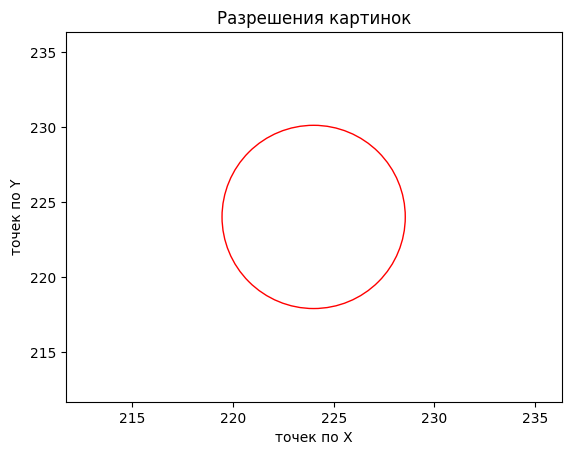

Статистика изображений в папке "res224_Selector"
	 {(224, 224, 3): 17405}
Выбранное разрешение для загрузки картинок:
	 (128, 128, 3)


In [ ]:
input_shape, img_stats = images_dir_stats(DATA_DIR, True)

img_width, img_height = input_shape[0], input_shape[1]

img_num_chanels = 3 #input_shape[2]
input_shape = (img_width, img_height, img_num_chanels)        # если задали руками

image_color_schem = ['grayscale','grayscale_alfa','rgb','rgba'][img_num_chanels - 1]

print(f'Статистика изображений в папке "{DATA_DIR}"')
print('\t',img_stats)
print('Выбранное разрешение для загрузки картинок:')
print('\t',input_shape)

In [ ]:
DATA_DIR = 'res224_Selector'
TRAIN_DIR = DATA_DIR + '/training'
VAL_DIR = DATA_DIR + '/validation'

img_width, img_height = 512, 512
image_color_schem = 'rgb'
img_num_chanels = len(image_color_schem)
input_shape = (img_width, img_height, img_num_chanels)   #!!! размерность по цветам получать  из изображени и  принудительно приводить

train_cnt = files_cnt(TRAIN_DIR)
val_cnt = files_cnt(VAL_DIR) 
cats = get_categories_labels(TRAIN_DIR)
num_classes = len(cats)

batch_size = 32 #round(train_cnt/100)

print(f'Всего изображений : \t{train_cnt + val_cnt}, в т.ч.')
print(f'\tTrain : \t{train_cnt}')
print(f'\tValidation : \t {val_cnt}\n ')
print(f'Классов : {num_classes}')
print(f'Batch_size : {batch_size}')


Всего изображений : 	17405, в т.ч.
	Train : 	15665
	Validation : 	 1740
 
Классов : 12
Batch_size : 32


#### Вариант 1 Используя Image_dataset_from_directory

In [ ]:
#from tensorflow.keras.preprocessing.image import image_dataset_from_directory

# чтобы сразу делить значения цветовых каналов. предполагаю, что слоем сетки это делать быстрее
#def parse_function(image, label):       
#    image = tf.divide(image, 255.0)
#    return image, label

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    image_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle=True,
    label_mode = 'categorical', # тип разметки - категориальные метки    
    color_mode = image_color_schem,
    crop_to_aspect_ratio = True,  # сохранять пропорции оригинала
    seed=42,
#    preprocessing_function = parse_function
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    image_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle=True,
    label_mode = 'categorical', # тип разметки - категориальные метки    
    color_mode = image_color_schem,
    crop_to_aspect_ratio = True,  # сохранять пропорции оригинала
    seed=42,
#    preprocessing_function = parse_function
)

# сохраним списки до перехода к RepeatDataset получим из датачета
# имена всех классов
class_names = train_data.class_names
# названия файлов у картинок
file_names = [str(file_name).split("/")[-1] for file_name in train_data.file_paths]

#-------------------------------------------------------------------
# если организовывать поток данных до обучения
shuffle_buffer_size = batch_size * 10  # 5000 # должно быть больше batches
AUTOTUNE = tf.data.AUTOTUNE

#train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE).repeat()
#val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE).repeat()


#train_data = train_data.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size=AUTOTUNE).batch(batch_size).repeat()
#val_data = val_data.cache().shuffle(buffer_size = shuffle_buffer_size).prefetch(buffer_size=AUTOTUNE).batch(batch_size).repeat()

# для бесконечного датасета
train_data = train_data.repeat()
val_data = val_data.repeat()

# дополнительная аугментация
# train_data = train_data.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
#                            num_parallel_calls=AUTOTUNE)

# val_data = val_data.map(lambda x, y: (tf.image.random_flip_left_right(x), y),
#                            num_parallel_calls=AUTOTUNE)


Found 14600 files belonging to 12 classes.
Found 1616 files belonging to 12 classes.


In [ ]:
# выбираем первые 9 элементов из перемешанного датасета
batch = train_data.take(1)
for images, labels in batch:
    labels = [class_names[np.argmax(i)] for i in labels.numpy()]


# выбираем первые 9 изображений
images = images[0,:9]
labels = labels[:9]
file_names = file_names[:9]

images, labels, file_names in zip(images, labels, file_names)

    # выводим выбранные изображения, метки и имена файлов
show_images(images = images, labels = labels, file_names = file_names, count=9)

#    for image, label, file_name in zip(images, labels, file_names):
#        print(f"Label: {label}, File Name: {file_name}")
#        tf.keras.preprocessing.image.array_to_img(image).show()


TypeError: ignored

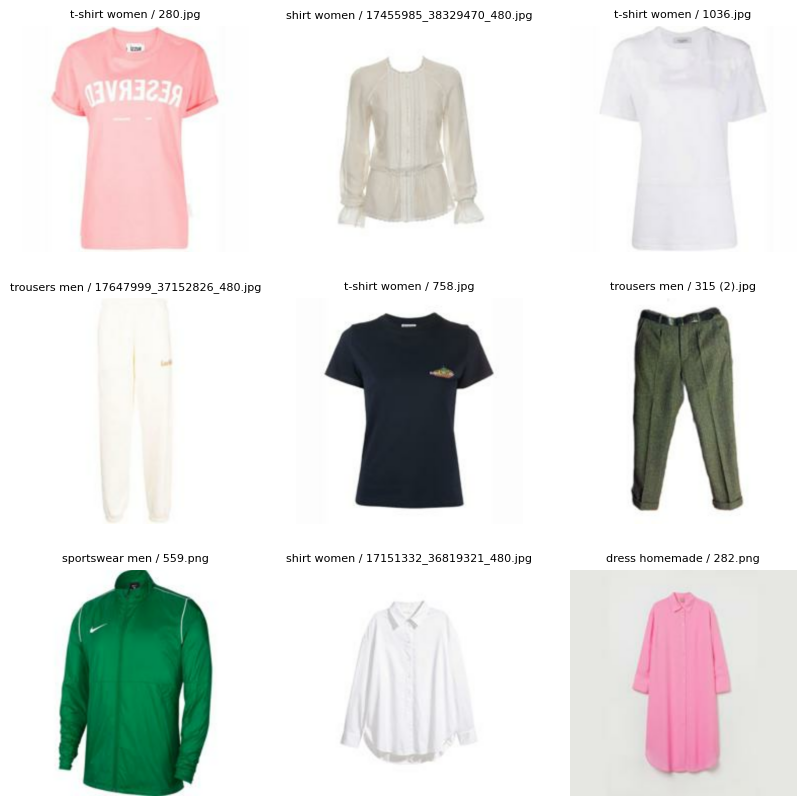

In [ ]:
count = 9
l_cnt = 9
h_cnt = 3
v_cnt  = 3


plt.figure(figsize=(10, 10))
for images, labels in  train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        ax.axis("off")
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title((f'{class_names[np.argmax(labels[i])]} / {file_names[i]}'), fontsize = 8)

